# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [ ]:
# import libraries here; add more as necessary
import os
import time
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import MeanShift

from sklearn.ensemble import AdaBoostRegressor # Adaptive Boosting
from sklearn.ensemble import GradientBoostingRegressor # Gradient Tree Boosting
from xgboost.sklearn import XGBRegressor # Extreme Gradient Boosting
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
import xgboost as xgb

from sklearn.metrics import roc_auc_score, fbeta_score, accuracy_score, precision_score, recall_score

from scipy import stats

# Visualizations
%matplotlib inline

# For reproducability
SEED = 2

# Disable Warnings
import warnings
warnings.filterwarnings('ignore')

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [ ]:
# load in the data
#azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
#customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

In [ ]:
# Loading data into azdias dataframe.
azdias = pd.read_csv('Udacity_AZDIAS_052018.csv',sep=';',low_memory=False)

In [ ]:
# Making a copy

azdias_copy = azdias.copy()

In [ ]:
# Function to load attribute values.
def load_avarto_data():
    """
    Loads attribute values and attribute information data
    
    Args:
        
    
    Returns:

        attribute_values : Attribute values DataFrame
        attribute_info : Attribute information DataFrame
        
    """
    
    # Ignore any empty columns while loading data
    no_unamed = lambda x: 'Unnamed' not in x
    
    attributes_values = pd.read_excel('DIAS Attributes - Values 2017.xlsx', header=1, usecols=no_unamed)
    attributes_info = pd.read_excel('DIAS Information Levels - Attributes 2017.xlsx', header=1, usecols=no_unamed)    
    
    return attributes_values, attributes_info

In [ ]:
attributes_values, attributes_info = load_avarto_data()

In [ ]:
# Check the structure of the data.
# Print fist 10 rows).
print(azdias_copy.shape)
azdias_copy.head()

(891221, 366)


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,...,REGIOTYP,RELAT_AB,RETOURTYP_BK_S,RT_KEIN_ANREIZ,RT_SCHNAEPPCHEN,RT_UEBERGROESSE,SEMIO_DOM,SEMIO_ERL,SEMIO_FAM,SEMIO_KAEM,SEMIO_KRIT,SEMIO_KULT,SEMIO_LUST,SEMIO_MAT,SEMIO_PFLICHT,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,SOHO_KZ,STRUKTURTYP,TITEL_KZ,UMFELD_ALT,UMFELD_JUNG,UNGLEICHENN_FLAG,VERDICHTUNGSRAUM,VERS_TYP,VHA,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,5.0,1.0,1.0,5.0,5.0,5.0,5.0,0,0,10,0,0,0,10,10,NaN,0,0,0,...,NaN,NaN,5.0,1.0,4.0,1.0,6,3,6,6,7,3,5,5,5,4,7,2,3,1,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,0.0,0.0,2.0,12.0,0.0,3.0,6.0,8A,8,51,5.0,1.0,5.0,5.0,2.0,3.0,1.0,1.0,0,0,10,0,0,0,10,10,NaN,0,0,0,...,3.0,4.0,1.0,5.0,3.0,5.0,7,2,4,4,4,3,2,3,7,6,4,5,6,1,3,1.0,2.0,0.0,3.0,3.0,1.0,0.0,2,0.0,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,0.0,0.0,1.0,7.0,0.0,3.0,2.0,4C,4,24,3.0,2.0,4.0,4.0,1.0,3.0,2.0,2.0,0,0,10,0,0,0,10,10,0.0,0,0,0,...,2.0,2.0,3.0,5.0,4.0,5.0,7,6,1,7,7,3,4,3,3,4,3,4,3,4,2,0.0,3.0,0.0,2.0,5.0,0.0,1.0,1,0.0,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0,4.0,2A,2,12,2.0,3.0,2.0,2.0,4.0,4.0,5.0,3.0,0,0,10,0,0,0,10,10,0.0,0,0,0,...,0.0,3.0,2.0,3.0,2.0,3.0,4,7,1,5,4,4,4,1,4,3,2,5,4,4,1,0.0,1.0,0.0,4.0,5.0,0.0,0.0,1,1.0,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,0.0,0.0,4.0,3.0,0.0,4.0,2.0,6B,6,43,5.0,3.0,3.0,3.0,3.0,4.0,3.0,3.0,3,5,5,1,2,0,10,5,10.0,6,6,1,...,5.0,5.0,5.0,3.0,5.0,5.0,2,4,4,2,3,6,4,2,4,2,4,6,2,7,2,0.0,3.0,0.0,4.0,3.0,0.0,1.0,2,0.0,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [ ]:
azdias_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(93), object(6)
memory usage: 2.4+ GB


In [ ]:
azdias_copy.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,...,REGIOTYP,RELAT_AB,RETOURTYP_BK_S,RT_KEIN_ANREIZ,RT_SCHNAEPPCHEN,RT_UEBERGROESSE,SEMIO_DOM,SEMIO_ERL,SEMIO_FAM,SEMIO_KAEM,SEMIO_KRIT,SEMIO_KULT,SEMIO_LUST,SEMIO_MAT,SEMIO_PFLICHT,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,SOHO_KZ,STRUKTURTYP,TITEL_KZ,UMFELD_ALT,UMFELD_JUNG,UNGLEICHENN_FLAG,VERDICHTUNGSRAUM,VERS_TYP,VHA,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,8.912210e+05,891221.000000,817722.000000,817722.000000,81058.000000,29499.000000,6170.000000,1205.000000,628274.000000,798073.000000,794213.000000,817722.000000,817722.000000,798073.000000,817722.000000,794005.000000,797481.000000,886367.000000,886367.000000,886367.000000,886367.000000,886367.000000,886367.000000,886367.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,634108.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,770025.000000,794005.00000,886367.000000,886367.000000,886367.000000,839995.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,817722.000000,793947.000000,817722.000000,793435.000000,793435.000000,817722.000000,793947.00000,891221.000000,817722.00000,770025.000000,815304.000000,815304.000000,815304.000000,783619.000000,817722.000000,798073.000000,891221.000000,891221.000000,891221.000000
mean,6.372630e+05,-0.358435,4.421928,10.864126,11.745392,13.402658,14.476013,15.089627,13.700717,8.287263,0.040647,0.154018,1.727637,7.599356,0.004162,3.167854,4.153043,3.632838,3.335264,3.368086,3.195014,3.351290,3.336151,3.360684,3.465980,0.122336,0.219907,9.267420,0.892735,0.568580,0.106769,9.926794,9.439073,0.705221,0.425645,0.467869,1.145516,0.485508,0.257938,1.585405,...,4.257967,3.07222,3.419630,3.233723,3.863797,3.023813,4.667550,4.481405,4.272729,4.445007,4.763223,4.025014,4.359086,4.001597,4.256076,3.910139,4.240609,3.945860,3.661784,4.023709,1.266967,0.008423,2.539212,0.003483,3.223125,4.017526,0.090067,4.58576,1.197852,0.43882,2.417322,6.001214,7.532130,5.945972,3.933406,7.908791,4.052836,3.362438,1.522098,2.777398
std,2.572735e+05,1.198724,3.638805,7.639683,4.097660,3.243300,2.712427,2.452932,5.079849,15.628087,0.324028,0.502389,1.155849,14.332201,0.068855,1.002376,2.183710,1.595021,1.493633,1.368331,1.401382,1.396508,1.373077,1.378992,1.328456,0.535950,0.747903,1.735725,2.011838,1.643764,0.808179,0.605641,1.547773,2.552707,1.510782,1.542151,2.266999,1.639340,1.252328,2.547925,...,2.030385,1.36298,1.417741,1.388687,1.282747,1.502725,1.795712,1.807552,1.915885,1.852412,1.830789,1.903816,2.022829,1.857540,1.770137,1.580306,2.007373,1.946564,1.707637,2.077746,1.287435,0.091392,0.754926,0.084957,1.255785,1.118399,0.286278,8.47152,0.952532,1.14329,1.166572,2.856091,3.247789,2.771464,1.964701,1.923137,1.949539,1.352704,0.499512,1.068775
min,1.916530e+05,-1.000000,1.000000,0.000000,2.000000,2.000000,4.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00

In [ ]:
#Loading customers data.
customers = pd.read_csv('Udacity_CUSTOMERS_052018.csv', sep=';', low_memory=False)

In [ ]:
# Making a copy of customers data.
customers_copy = customers.copy()

In [ ]:
print(customers_copy.shape)
customers_copy.head()

(191652, 369)


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,...,RT_KEIN_ANREIZ,RT_SCHNAEPPCHEN,RT_UEBERGROESSE,SEMIO_DOM,SEMIO_ERL,SEMIO_FAM,SEMIO_KAEM,SEMIO_KRIT,SEMIO_KULT,SEMIO_LUST,SEMIO_MAT,SEMIO_PFLICHT,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,SOHO_KZ,STRUKTURTYP,TITEL_KZ,UMFELD_ALT,UMFELD_JUNG,UNGLEICHENN_FLAG,VERDICHTUNGSRAUM,VERS_TYP,VHA,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,0.0,0.0,2.0,1.0,0.0,1.0,3.0,1A,1,13,5.0,4.0,1.0,1.0,5.0,5.0,5.0,5.0,0,0,10,0,0,0,10,10,0.0,0,0,0,...,1.0,5.0,3.0,1,3,5,1,3,4,7,6,2,1,2,6,1,6,3,0.0,3.0,0.0,4.0,4.0,0.0,8.0,1,0.0,3.0,5.0,3.0,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,3.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,6,0,5,0,10,10,0.0,6,0,0,...,NaN,NaN,NaN,3,3,6,2,3,4,5,6,4,1,2,3,1,7,3,0.0,NaN,0.0,NaN,NaN,0.0,NaN,1,0.0,NaN,6.0,6.0,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,0.0,0.0,1.0,1.0,0.0,3.0,7.0,5D,5,34,2.0,5.0,2.0,2.0,5.0,5.0,5.0,5.0,0,0,10,0,0,0,10,10,0.0,0,0,0,...,1.0,5.0,1.0,5,7,2,6,7,1,7,3,4,2,1,2,1,3,1,0.0,3.0,0.0,1.0,5.0,0.0,0.0,2,0.0,4.0,10.0,13.0,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,NaN,0.0,0.0,1.0,0.0,1.0,7.0,4C,4,24,2.0,5.0,1.0,1.0,5.0,5.0,5.0,5.0,0,0,10,0,0,0,10,10,0.0,0,0,0,...,1.0,5.0,2.0,3,3,5,3,3,4,5,4,3,3,3,6,4,7,0,0.0,1.0,0.0,3.0,4.0,0.0,0.0,1,0.0,2.0,6.0,4.0,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,0.0,0.0,4.0,7.0,0.0,3.0,3.0,7B,7,41,6.0,4.0,3.0,3.0,3.0,4.0,3.0,3.0,1,2,3,5,0,3,10,7,0.0,0,0,6,...,4.0,3.0,5.0,5,4,5,2,3,5,6,6,5,5,4,4,4,5,1,0.0,3.0,0.0,2.0,4.0,0.0,1.0,2,0.0,4.0,3.0,5.0,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [ ]:
customers_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Columns: 369 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(94), object(8)
memory usage: 539.5+ MB


In [ ]:
customers_copy.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,...,RELAT_AB,RETOURTYP_BK_S,RT_KEIN_ANREIZ,RT_SCHNAEPPCHEN,RT_UEBERGROESSE,SEMIO_DOM,SEMIO_ERL,SEMIO_FAM,SEMIO_KAEM,SEMIO_KRIT,SEMIO_KULT,SEMIO_LUST,SEMIO_MAT,SEMIO_PFLICHT,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,SOHO_KZ,STRUKTURTYP,TITEL_KZ,UMFELD_ALT,UMFELD_JUNG,UNGLEICHENN_FLAG,VERDICHTUNGSRAUM,VERS_TYP,VHA,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,191652.000000,191652.000000,145056.000000,145056.000000,11766.000000,5100.000000,1275.000000,236.000000,139810.000000,141725.000000,139542.000000,145056.000000,145056.000000,141725.000000,145056.000000,141176.000000,141693.000000,188439.000000,188439.00000,188439.000000,188439.000000,188439.000000,188439.000000,188439.000000,188439.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,143955.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,...,141176.000000,188439.000000,188439.000000,188439.000000,147460.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,145056.000000,141176.000000,145056.000000,141204.000000,141204.000000,145056.000000,141176.000000,191652.000000,145056.000000,137392.000000,143781.000000,143781.000000,143781.000000,137910.000000,145056.000000,141725.000000,191652.000000,191652.000000,191652.000000,191652.000000
mean,95826.500000,0.344359,1.747525,11.352009,12.337243,13.672353,14.647059,15.377119,10.331579,4.965863,0.067413,0.136402,2.267828,4.701288,0.020392,2.824850,4.301758,3.677928,4.00994,2.665441,2.548490,4.516369,4.415317,4.519956,4.538838,0.091040,0.159524,9.367599,0.646166,0.424478,0.132970,9.866472,9.600646,0.462019,0.444477,0.978727,1.527780,0.998565,0.538492,2.443987,...,2.898510,3.716311,2.462484,4.528516,2.519653,4.483835,4.408021,4.414026,4.187246,4.674535,3.682497,5.366477,3.883163,3.528254,3.165879,4.112788,3.742137,2.919161,4.185279,0.987754,0.009865,2.567759,0.021681,2.968011,4.335770,0.084747,5.055087,0.849008,0.868534,2.429508,4.374417,4.564769,3.168868,4.152716,8.646371,3.723133,2.576806,0.090247,1.376432,3.060907
std,55325.311233,1.391672,1.966334,6.275026,4.006050,3.243335,2.753787,2.307653,4.134828,14.309694,0.545576,0.493249,1.390620,14.184081,0.152234,1.012415,2.114614,1.813975,1.37894,1.545714,1.557262,0.874722,1.025281,0.895371,0.886091,0.416684,0.589824,1.643262,1.771525,1.443739,0.907925,0.772253,1.379280,2.087402,1.546226,2.097215,2.562741,2.215235,1.746448,2.822639,...,1.422683,1.113933,1.315405,0.939708,1.356235,1.631941,1.720909,1.733128,1.872047,2.041059,1.573090,1.443103,1.840131,1.493916,1.316221,2.070958,1.718039,1.219224,2.367407,1.538679,0.098833,0.724788,0.210424,1.312128,0.979701,0.278505,9.250235,1.166162,1.320530,1.148821,2.924355,2.887035,2.233516,1.974375,1.154001,2.095540,1.168486,0.286536,0.484492,1.086254
min,1.000000,-1.000000,1.000000,0.000000,2.000000,2.000000,5.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,..

## Part 0.1: Data Exploration & Visualization

In [ ]:
# finding missing data.
# get number of NULL data in azdias.
# total number of fields with NULL
azdias_null = azdias_copy.isnull().sum()
azdias_null_percent = azdias_null / len(azdias_copy) * 100

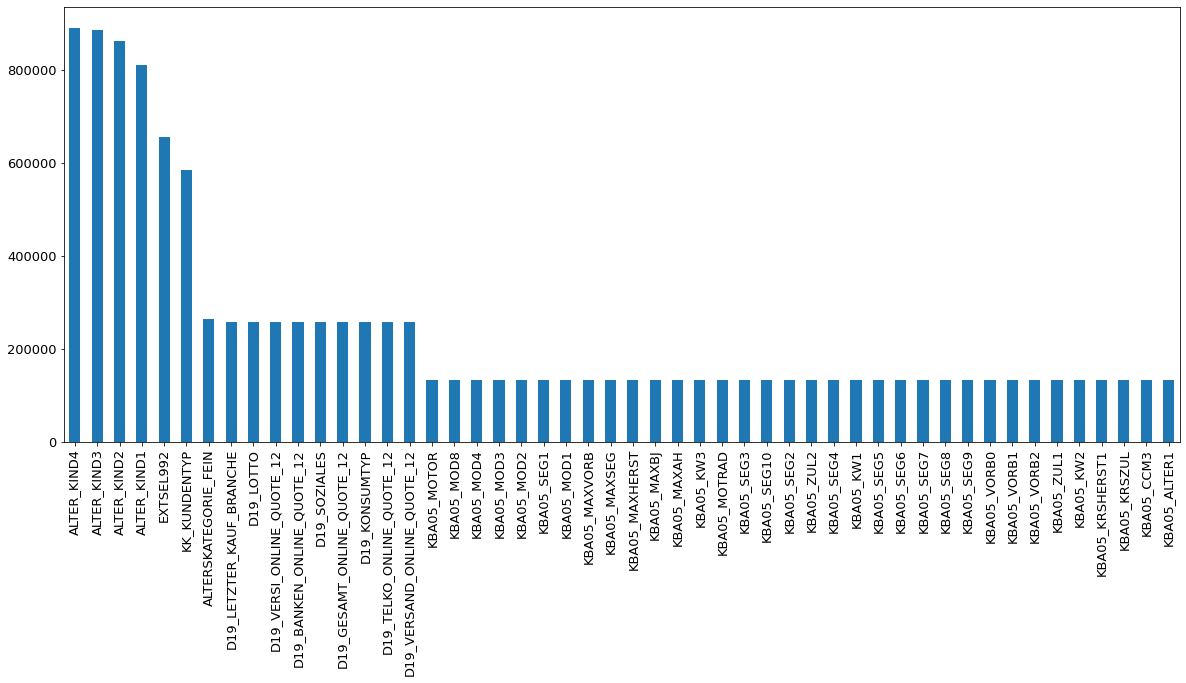

In [ ]:
# visualise missing data
(azdias_null.sort_values(ascending=False)[:50].plot(kind='bar', figsize=(20,8), fontsize=13))

*>> From the above chart we can infer that there is high amount of missing data to be corrected*

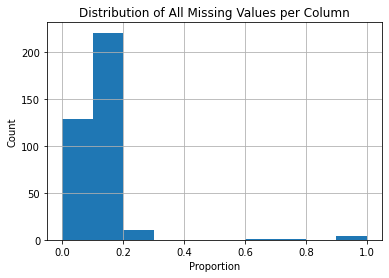

In [ ]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
missing_col = azdias_copy.isnull().sum()/azdias_copy.shape[0]

missing_col.hist()
plt.xlabel('Proportion')
plt.ylabel('Count')
plt.title('Distribution of All Missing Values per Column');

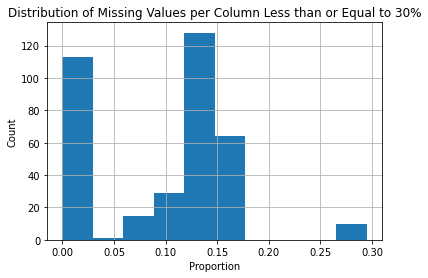

In [ ]:
# Investigate patterns in the amount of missing data in each column.
missing_col_sub = missing_col[missing_col <= 0.3]

missing_col_sub.hist()
plt.xlabel('Proportion')
plt.ylabel('Count')
plt.title('Distribution of Missing Values per Column Less than or Equal to 30%');

In [ ]:
# Printing the  missing % distribution to check for the presence of outliers.
print('columns having  missing values >0% : ',len(azdias_null_percent[azdias_null_percent>0].index))
print('columns having  missing values >10%: ',len(azdias_null_percent[azdias_null_percent>10].index))
print('columns having  missing values >20%: ',len(azdias_null_percent[azdias_null_percent>20].index))
print('columns having  missing values >30%: ',len(azdias_null_percent[azdias_null_percent>30].index))
print('columns having  missing values >40%: ',len(azdias_null_percent[azdias_null_percent>40].index))
print('columns having  missing values >60%: ',len(azdias_null_percent[azdias_null_percent>60].index))
print('columns having  missing values >65%: ',len(azdias_null_percent[azdias_null_percent>65].index))
print('columns having  missing values >80%: ',len(azdias_null_percent[azdias_null_percent>80].index))
print('columns having  missing values >90%: ',len(azdias_null_percent[azdias_null_percent>90].index))

columns having  missing values >0% :  273
columns having  missing values >10%:  237
columns having  missing values >20%:  16
columns having  missing values >30%:  6
columns having  missing values >40%:  6
columns having  missing values >60%:  6
columns having  missing values >65%:  6
columns having  missing values >80%:  4
columns having  missing values >90%:  4


## Part: 0.2 Data Preprocessing

In [ ]:
azdias_copy = azdias_copy[azdias_copy.isnull().sum(axis=1) <= 16].reset_index(drop=True)
print('Number of rows in new dataset: ',azdias_copy.shape[0])

Number of rows in new dataset:  733227


In [ ]:
# Retriving the number of null values in both datasets.
row_nans = azdias_copy.isnull().sum(axis=1)
column_nans = azdias_copy.isnull().mean()

In [ ]:
# Dropping the columns where the value of missing data is > 65%

drop_cols = azdias_copy.columns[column_nans > 0.65]
print('columns to drop: ', drop_cols)

columns to drop:  Index(['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4',
       'EXTSEL992'],
      dtype='object')


In [ ]:
print('number of rows in new dataset: ',azdias_copy.shape[0])

number of rows in new dataset:  733227


In [ ]:
# Drop the extra column of customers dataset.

customers_copy.drop(columns=['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'], inplace=True)

In [ ]:
print('# of column in azdias before dropping: ', len(azdias_copy.columns))
azdias_copy = azdias_copy.drop(drop_cols,axis=1)
print('# of column in azdias after dropping: ', len(azdias_copy.columns))

print('# of column in customers before dropping: ', len(customers_copy.columns))
customers_copy = customers_copy.drop(drop_cols,axis=1)
print('# of column in customers after dropping: ', len(customers_copy.columns))

# of column in azdias before dropping:  366
# of column in azdias after dropping:  361
# of column in customers before dropping:  366
# of column in customers after dropping:  361


In [ ]:
print('number of rows in new dataset: ',azdias_copy.shape)
print('number of rows in new dataset: ',customers_copy.shape)

number of rows in new dataset:  (733227, 361)
number of rows in new dataset:  (191652, 361)


In [ ]:
# object field EINGEFUEGT_AM has too many different items. Dropping from dataset

azdias_copy = azdias_copy.drop(['EINGEFUEGT_AM'],axis=1)
customers_copy = customers_copy.drop(['EINGEFUEGT_AM'],axis=1)

In [ ]:
# object field D19_LETZTER_KAUF_BRANCHE has many different items. Dropping from dataset

azdias_copy = azdias_copy.drop(['D19_LETZTER_KAUF_BRANCHE'],axis=1)
customers_copy = customers_copy.drop(['D19_LETZTER_KAUF_BRANCHE'],axis=1)

In [ ]:
%%time
# Clean up  - removing columns columns after one-hot encoding
# Removing highly correlated columns


# find correlation matrix    
corr_matrix = azdias_copy.corr().abs()
upper_limit = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
# identify columns to drop based on threshold limit
drop_columns = [column for column in upper_limit.columns if any(upper_limit[column] > .7)]
# drop columns from azdias
azdias_copy = azdias_copy.drop(drop_columns, axis=1)
print('number of columns', len(azdias_copy.columns))

# repeat for customers
# find correlation matrix    
corr_matrix = customers_copy.corr().abs()
upper_limit = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
# identify columns to drop based on threshold limit
drop_columns = [column for column in upper_limit.columns if any(upper_limit[column] > .7)]
# drop columns from azdias
customers_copy = customers_copy.drop(drop_columns, axis=1)
print('number of columns', len(customers_copy.columns))

number of columns 238
number of columns 256
CPU times: user 4min 53s, sys: 1.17 s, total: 4min 54s
Wall time: 4min 53s


In [ ]:
print('number of rows in new dataset: ',azdias_copy.shape)
print('number of rows in new dataset: ',customers_copy.shape)

number of rows in new dataset:  (733227, 238)
number of rows in new dataset:  (191652, 256)


In [ ]:
# Removed columns with  missing values that do not add value. Let's explore columns with object data type.
azdias_copy.select_dtypes(include=['object'])

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,OST_WEST_KZ
0,8A,8,51,W
1,4C,4,24,W
2,2A,2,12,W
3,6B,6,43,W
4,8C,8,54,W
...,...,...,...,...
733222,7A,7,41,W
733223,9D,9,51,W
733224,4C,4,24,W
733225,9D,9,51,W


In [ ]:
customers_copy.select_dtypes(include=['object']).head()

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,OST_WEST_KZ
0,1A,1,13,W
1,NaN,NaN,NaN,NaN
2,5D,5,34,W
3,4C,4,24,W
4,7B,7,41,W


In [ ]:
# Finding categorical fields.

cols = azdias_copy.columns
num_cols = azdias_copy._get_numeric_data().columns
print('num_cols: ',num_cols)
print('categorical: ',list(set(cols) - set(num_cols)))

num_cols:  Index(['LNR', 'AGER_TYP', 'AKT_DAT_KL', 'ALTER_HH', 'ALTERSKATEGORIE_FEIN',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'ANZ_KINDER', 'ANZ_PERSONEN',
       'ANZ_TITEL',
       ...
       'UMFELD_ALT', 'UMFELD_JUNG', 'UNGLEICHENN_FLAG', 'VERDICHTUNGSRAUM',
       'VERS_TYP', 'VHA', 'VHN', 'W_KEIT_KIND_HH', 'WOHNLAGE', 'ZABEOTYP'],
      dtype='object', length=234)
categorical:  ['OST_WEST_KZ', 'CAMEO_INTL_2015', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [ ]:
# filling in missing values with -1 indicating unknown as in the description.

azdias_copy[['CAMEO_DEUG_2015','CAMEO_INTL_2015']] = azdias_copy[['CAMEO_DEUG_2015','CAMEO_INTL_2015']].replace(['X','XX'],-1)
customers_copy[['CAMEO_DEUG_2015','CAMEO_INTL_2015']] = customers_copy[['CAMEO_DEUG_2015','CAMEO_INTL_2015']].replace(['X','XX'],-1)
azdias_copy[['CAMEO_DEUG_2015','CAMEO_INTL_2015']] = azdias_copy[['CAMEO_DEUG_2015','CAMEO_INTL_2015']].fillna(-1)
customers_copy[['CAMEO_DEUG_2015','CAMEO_INTL_2015']] = customers_copy[['CAMEO_DEUG_2015','CAMEO_INTL_2015']].fillna(-1)
azdias_copy[['CAMEO_DEUG_2015','CAMEO_INTL_2015']] = azdias_copy[['CAMEO_DEUG_2015','CAMEO_INTL_2015']].astype(int)
customers_copy[['CAMEO_DEUG_2015','CAMEO_INTL_2015']] = customers_copy[['CAMEO_DEUG_2015','CAMEO_INTL_2015']].astype(int)
azdias_copy[['CAMEO_DEU_2015','OST_WEST_KZ']]=azdias_copy[['CAMEO_DEU_2015','OST_WEST_KZ']].fillna(-1)
customers_copy[['CAMEO_DEU_2015','OST_WEST_KZ']]=customers_copy[['CAMEO_DEU_2015','OST_WEST_KZ']].fillna(-1)

In [ ]:
customers_copy.isnull().sum()

LNR                         0
AGER_TYP                    0
AKT_DAT_KL              46596
ALTER_HH                46596
ALTERSKATEGORIE_FEIN    51842
                        ...  
VK_DHT4A                47871
W_KEIT_KIND_HH          53742
WOHNDAUER_2008          46596
WOHNLAGE                49927
ZABEOTYP                    0
Length: 256, dtype: int64

In [ ]:
azdias_copy.isnull().sum()

LNR                          0
AGER_TYP                     0
AKT_DAT_KL                   0
ALTER_HH                     0
ALTERSKATEGORIE_FEIN    167182
                         ...  
VHA                          0
VHN                       6250
W_KEIT_KIND_HH           22129
WOHNLAGE                     0
ZABEOTYP                     0
Length: 238, dtype: int64

In [ ]:
# fillna with 9 for fields that has 9 marked as unknown

azdias_copy[azdias_copy.columns[(azdias_copy==9).any()]] = azdias_copy[azdias_copy.columns[(azdias_copy==9).any()]].fillna(9)
customers_copy[customers_copy.columns[(customers_copy==9).any()]] = customers_copy[customers_copy.columns[(customers_copy==9).any()]].fillna(9)

In [ ]:
%%time
# fillna with 0 for fields that has 0 marked as unknown

azdias_copy[azdias_copy.columns[(azdias_copy==0).any()]] = azdias_copy[azdias_copy.columns[(azdias_copy==0).any()]].fillna(0)
customers_copy[customers_copy.columns[(customers_copy==0).any()]] = customers_copy[customers_copy.columns[(customers_copy==0).any()]].fillna(0)

CPU times: user 2.74 s, sys: 94.9 ms, total: 2.84 s
Wall time: 2.29 s


In [ ]:
%time
# fillna with -1 for fields that has 0 marked as unknown

azdias_copy[azdias_copy.columns[(azdias_copy==-1).any()]] = azdias_copy[azdias_copy.columns[(azdias_copy==-1).any()]].fillna(-1)
customers_copy[customers_copy.columns[(customers_copy==-1).any()]] = customers_copy[customers_copy.columns[(customers_copy==-1).any()]].fillna(-1)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.87 µs


In [ ]:
%%time
#with  all null data now handled, we should focus on getting objects/categorical variables to numbers via one hot encoding

azdias_copy = pd.get_dummies(azdias_copy)
customers_copy = pd.get_dummies(customers_copy)

CPU times: user 1.31 s, sys: 1.13 s, total: 2.44 s
Wall time: 2.51 s


In [ ]:
print('number of rows in new dataset: ',azdias_copy.shape)
print('number of rows in new dataset: ',customers_copy.shape)

number of rows in new dataset:  (733227, 284)
number of rows in new dataset:  (191652, 303)


In [ ]:
print(azdias_copy.columns)

Index(['LNR', 'AGER_TYP', 'AKT_DAT_KL', 'ALTER_HH', 'ALTERSKATEGORIE_FEIN',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'ANZ_KINDER', 'ANZ_PERSONEN',
       'ANZ_TITEL',
       ...
       'CAMEO_DEU_2015_8C', 'CAMEO_DEU_2015_8D', 'CAMEO_DEU_2015_9A',
       'CAMEO_DEU_2015_9B', 'CAMEO_DEU_2015_9C', 'CAMEO_DEU_2015_9D',
       'CAMEO_DEU_2015_9E', 'CAMEO_DEU_2015_XX', 'OST_WEST_KZ_O',
       'OST_WEST_KZ_W'],
      dtype='object', length=284)


In [ ]:
print(customers_copy.columns)

Index(['LNR', 'AGER_TYP', 'AKT_DAT_KL', 'ALTER_HH', 'ALTERSKATEGORIE_FEIN',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'ANZ_KINDER', 'ANZ_PERSONEN',
       'ANZ_TITEL',
       ...
       'CAMEO_DEU_2015_8D', 'CAMEO_DEU_2015_9A', 'CAMEO_DEU_2015_9B',
       'CAMEO_DEU_2015_9C', 'CAMEO_DEU_2015_9D', 'CAMEO_DEU_2015_9E',
       'CAMEO_DEU_2015_XX', 'OST_WEST_KZ_-1', 'OST_WEST_KZ_O',
       'OST_WEST_KZ_W'],
      dtype='object', length=303)


In [ ]:
azdias_copy_columns = azdias_copy.columns
customers_copy_columns = customers_copy.columns

In [ ]:
# impute nans using mode value

imputer = SimpleImputer(missing_values=np.NaN,strategy='mean')

azdias_copy = imputer.fit_transform(azdias_copy)
azdias_copy = pd.DataFrame(azdias_copy)
print('imputed azdias: ', azdias_copy.head(5))

customers_copy = imputer.fit_transform(customers_copy)
customers_copy = pd.DataFrame(customers_copy)
print('imputed customers: ', customers_copy.head(5))

imputed azdias:          0    1    2     3     4     5    6    ...  277  278  279  280  281  282  283
0  910220.0 -1.0  9.0   0.0  21.0  11.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  1.0
1  910225.0 -1.0  9.0  17.0  17.0  10.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  1.0
2  910226.0  2.0  1.0  13.0  13.0   1.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  1.0
3  910241.0 -1.0  1.0  20.0  14.0   3.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  1.0
4  910244.0  3.0  1.0  10.0  10.0   5.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  1.0

[5 rows x 284 columns]
imputed customers:          0    1    2     3     4    5    6    ...  296  297  298  299  300  301  302
0    9626.0  2.0  1.0  10.0  10.0  1.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  1.0
1    9628.0 -1.0  9.0  11.0   9.0  9.0  9.0  ...  0.0  0.0  0.0  0.0  1.0  0.0  0.0
2  143872.0 -1.0  1.0   6.0   0.0  1.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  1.0
3  143873.0  1.0  1.0   8.0   8.0  0.0  9.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  1.0
4  143874

In [ ]:
print('number of rows in new dataset: ',azdias_copy.shape)
print('number of rows in new dataset: ',customers_copy.shape)

number of rows in new dataset:  (733227, 284)
number of rows in new dataset:  (191652, 303)


In [ ]:
# convert to int
azdias_copy = azdias_copy.astype(int)
customers_copy = customers_copy.astype(int)

### Part 0.3 Outlier detection and removal.

In [ ]:
%%time
# detect and exclude outliers in dataframe
#  remove all rows that have outliers in at least one column

azdias_copy = azdias_copy[(np.abs(stats.zscore(azdias_copy)) < 6).all(axis=1)]
customers_copy = customers_copy[(np.abs(stats.zscore(customers_copy)) < 6).all(axis=1)]

CPU times: user 4.73 s, sys: 2.52 s, total: 7.26 s
Wall time: 7.25 s


In [ ]:
print('number of rows in new dataset: ',azdias_copy.shape)
print('number of rows in new dataset: ',customers_copy.shape)

number of rows in new dataset:  (415405, 284)
number of rows in new dataset:  (100341, 303)


### Part 0.4: Standardize Data.

In [ ]:
%%time
# scale the data
scale = StandardScaler(copy=False)

#scale = MinMaxScaler(copy=False)
azdias_copy[azdias_copy.columns] = scale.fit_transform(azdias_copy)

In [ ]:
%%time
# scale the data

customers[customers.columns] = scale.fit_transform(customers)

CPU times: user 17.5 s, sys: 1.5 s, total: 19 s
Wall time: 18.9 s


### 0.5 Implementation

In [ ]:
def data_clean(df, for_clustering, df_name=None):
    
    if for_clustering:
        if df_name == 'azdias':
            df = df[df.isnull().sum(axis=1) <= 16].reset_index(drop=True)
        elif df_name == 'customers':            
            df.drop(columns=['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'], inplace=True)
        
    #column_nans = df.isnull().mean()
    drop_cols = ['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'EXTSEL992','KK_KUNDENTYP']
    
    df = df.drop(drop_cols,axis=1)
    df = df.drop(['EINGEFUEGT_AM'],axis=1)
    df = df.drop(['D19_LETZTER_KAUF_BRANCHE'],axis=1)


    # find correlation matrix    
    corr_matrix = df.corr().abs()
    upper_limit = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    # identify columns to drop based on threshold limit
    drop_columns = [column for column in upper_limit.columns if any(upper_limit[column] > .7)]
    # drop columns from df
    df = df.drop(drop_columns, axis=1)
    print('shape after corr', df.shape)


    # we need to fill missing values here. We will fill missing values with -1 indicating unknown as in the description.
    df[['CAMEO_DEUG_2015','CAMEO_INTL_2015']] = df[['CAMEO_DEUG_2015','CAMEO_INTL_2015']].replace(['X','XX'],-1)
    df[['CAMEO_DEUG_2015','CAMEO_INTL_2015']] = df[['CAMEO_DEUG_2015','CAMEO_INTL_2015']].fillna(-1)
    df[['CAMEO_DEUG_2015','CAMEO_INTL_2015']] = df[['CAMEO_DEUG_2015','CAMEO_INTL_2015']].astype(int)
    df[['CAMEO_DEU_2015','OST_WEST_KZ']]=df[['CAMEO_DEU_2015','OST_WEST_KZ']].fillna(-1)
# fillna with 9 for fields that has 9 marked as unknown
    df[df.columns[(df==9).any()]] = df[df.columns[(df==9).any()]].fillna(9)

    # fillna with 0 for fields that has 0 marked as unknown
    df[df.columns[(df==0).any()]] = df[df.columns[(df==0).any()]].fillna(0)

    # fillna with -1 for fields that has 0 marked as unknown
    df[df.columns[(df==-1).any()]] = df[df.columns[(df==-1).any()]].fillna(-1)


    
    #print('col name before: ', df.columns)
    #with  all null data now handled, we should focus on getting objects/categorical variables to numbers via one hot encoding
    df = pd.get_dummies(df)
    #print('col name after: ', df.columns)
    print('shape after one-hot', df.shape)
    
    df_columns = list(df.columns.values)

    # impute nans using mode value
    imputer = SimpleImputer(missing_values=np.NaN,strategy='mean')
    df = imputer.fit_transform(df)
    df = pd.DataFrame(df)
    #print('imputed dataframe: ', df.head(5))
    print('shape after impute', df.shape)
    
    
    
    # convert to int
    df = df.astype(int)


    # detect and exclude outliers in dataframe
    #  remove all rows that have outliers in at least one column   
    if for_clustering:
        print('inside outliers if')
        df = df[(np.abs(stats.zscore(df)) < 6).all(axis=1)] 
        print('shape before scaling', df.shape)
    # scale the data
    scale = StandardScaler(copy=False)
    scaled = scale.fit_transform(df)
    df = pd.DataFrame(scaled,columns= df_columns)
    print('shape after scaling', df.shape)
    #else:
    #    df.columns = df_columns
        
    df = df.set_index('LNR')
    return df

In [ ]:
azdias = data_clean(azdias, True, 'azdias')
print(azdias.shape)
print(azdias.head(5))

shape after corr (733227, 238)
shape after one-hot (733227, 284)
shape after impute (733227, 284)
inside outliers if
shape before scaling (415405, 284)
shape after scaling (415405, 284)
(415405, 283)
          AGER_TYP  AKT_DAT_KL  ...  OST_WEST_KZ_O  OST_WEST_KZ_W
LNR                             ...                              
1.044527 -0.549413    1.155132  ...      -0.509642       0.509642
1.044589 -0.549413   -1.017213  ...      -0.509642       0.509642
1.044600  2.747309   -1.017213  ...      -0.509642       0.509642
1.044616 -0.549413    1.155132  ...      -0.509642       0.509642
1.044666 -0.549413   -1.017213  ...      -0.509642       0.509642

[5 rows x 283 columns]


In [ ]:
%%time
customers = data_clean(customers, True, 'customers')
print(customers.shape)
print(customers.head(5))

shape after corr (191652, 256)
shape after one-hot (191652, 303)
shape after impute (191652, 303)
inside outliers if
shape before scaling (100341, 303)
shape after scaling (100341, 303)
(100341, 302)
           AGER_TYP  AKT_DAT_KL  ...  OST_WEST_KZ_O  OST_WEST_KZ_W
LNR                              ...                              
-1.556361 -0.738505    1.010105  ...      -0.164221      -0.961907
 0.872952  0.777112   -1.037635  ...      -0.164221       1.039601
 0.873622  0.777112   -1.037635  ...      -0.164221       1.039601
 0.118344  0.777112   -1.037635  ...      -0.164221       1.039601
 0.118561  0.777112   -1.037635  ...      -0.164221       1.039601

[5 rows x 302 columns]
CPU times: user 1min 31s, sys: 328 ms, total: 1min 31s
Wall time: 1min 31s


## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

## Part 1.1: Dimensionality reduction

As the number of features in the data is relatively high, we can verify the variance explained by each feature in the dataset. By using a dimensionality reduction technique, we can effectively reduce the number of features which do not vary much in the data. using Principal Component Analysis(PCA).


In [ ]:
def perform_pca(data, n_components=None):
    pca = PCA(n_components, random_state=SEED)
    pca.fit(data)
    data_transformed = pca.transform(data)
    return pca, data_transformed

In [ ]:
pca_azdias, _ = perform_pca(azdias, None)

In [ ]:
def plot_pca_exp_variance(pca_azdias, cumulative=True, figsize=(8,10)):
    """
    Takes in two PCA models (which are fit on corresponding data) and plots 
    their Explained Variance vs Number of components
    
    """   
    
    if cumulative:
        azdias_variance = np.cumsum(pca_azdias.explained_variance_ratio_)
        y_label = "Percentage Explained Variance"
    else:
        azdias_variance = pca_azdias.explained_variance_ratio_
        y_label = "Explained Variance Ratio"
        
    fig = plt.figure(figsize=figsize)

    ax = fig.add_subplot(211)
    ax.plot(azdias_variance)
    ax.set_xlabel("No. of components")
    ax.set_ylabel(y_label)
    ax.set_title("Azdias - PCA Explained Variance Ratio vs Number of Components")
    ax.grid()
    plt.show()

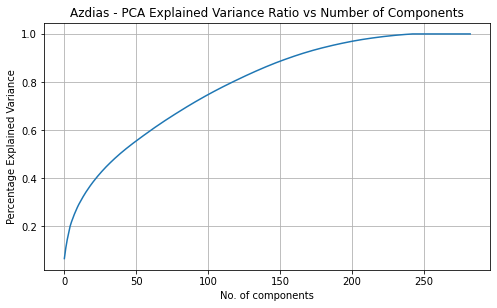

In [ ]:
plot_pca_exp_variance(pca_azdias)

From the explained variance plot it is observed that around 150 components explain 90% of variance in the dataset. We can set the number of components to 150 and perform PCA analysis to have 150 components and observe the feature importances for each component, to understand what each PCA component represents.

In [ ]:
pca_150, azdias_pca_150 = perform_pca(azdias, n_components=150)

In [ ]:
c_pca_150, customers_pca_150 = perform_pca(customers, n_components=150)

### 1.1.1 Interpreting PCA components

We can now look at the feature weights given by the PCA algorithm and understand what each component is comprised of. We can write a function to get information about the top n positive features and top n negative features for a given component.

In [ ]:
def plot_feature_weights(df, pca, attributes_info, dimension, n_weights = 5, plot=True,figsize=(7,8)):
    """
    This function displays interesting features of the selected dimension
    """
    
    features = df.columns.values
    components = pca.components_
    feature_weights = dict(zip(features, components[dimension]))
    sorted_weights = sorted(feature_weights.items(), key = lambda kv: kv[1])
    
    feat_names = []
    feat_weights = []
    feat_descs = []

    for feature, weight in sorted_weights[-n_weights:]:
        feat_names.append(feature)
        feat_weights.append(weight)
        
    for feature, weight, in sorted_weights[:n_weights]:
        feat_names.append(feature)
        feat_weights.append(weight)
        
    for feature in feat_names:
        if feature in attributes_info.Attribute.values:
            feat_descs.append(attributes_info[attributes_info.Attribute == feature].Description.values[0])
        else:
            feat_descs.append("No description given")
    
    component_info = {"Feature":feat_names, "Description":feat_descs, "FeatureWeight":feat_weights}
    component_info = pd.DataFrame(component_info)
    component_info.sort_values("FeatureWeight", inplace=True, ascending=False, ignore_index=True)
    
    if plot:
        fig = plt.figure(figsize=figsize)

        ax = fig.add_subplot(211)
        ax.bar(feat_names, feat_weights)
        ax.set_ylabel("Feature Weight")
        ax.set_xlabel("Feature Name")
        ax.set_title("PCA Feature weights - Component {}".format(dimension))
        for tick in ax.get_xticklabels():
            tick.set_rotation(45)
        ax.grid()

        fig.tight_layout()
        plt.show()
    
    return component_info

 ##### **Component 0**

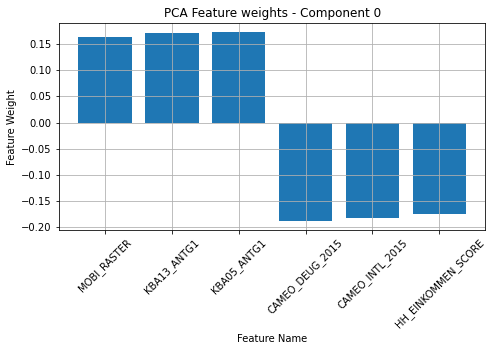

,Feature,Description,FeatureWeight
0,KBA05_ANTG1,number of 1-2 family houses in the cell,0.172005
1,KBA13_ANTG1,No description given,0.171904
2,MOBI_RASTER,No description given,0.163316
3,HH_EINKOMMEN_SCORE,estimated household_net_income,-0.175161
4,CAMEO_INTL_2015,No description given,-0.182696
5,CAMEO_DEUG_2015,CAMEO_4.0: uppergroup,-0.187231


In [ ]:
component_0_info = plot_feature_weights(azdias, pca_azdias, attributes_info, 0, 3)
component_0_info.head(10)

Component 0:

* Has a high positive weight to number of 1-2 family houses in the cell.
* High weight for KBA13_ANTG1 and MOBI_RASTER.

##### **Component 1**

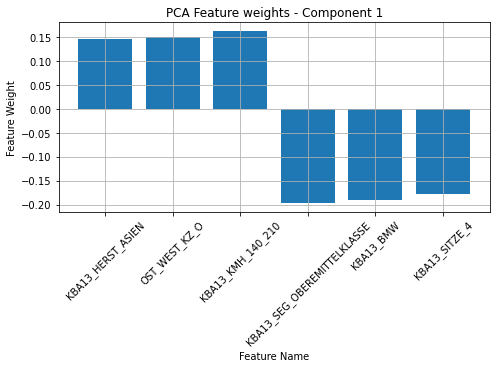

,Feature,Description,FeatureWeight
0,KBA13_KMH_140_210,share of cars with max speed between 140 and 2...,0.162871
1,OST_WEST_KZ_O,No description given,0.150235
2,KBA13_HERST_ASIEN,share of asian cars within the PLZ8,0.145746
3,KBA13_SITZE_4,number of cars with less than 5 seats in the PLZ8,-0.177314
4,KBA13_BMW,share of BMW within the PLZ8,-0.190939
5,KBA13_SEG_OBEREMITTELKLASSE,share of upper middle class cars and upper cla...,-0.197146


In [ ]:
component_1_info = plot_feature_weights(azdias, pca_azdias, attributes_info, 1, 3)
component_1_info.head(10)

Component 1:

* Has a high positive weight for share of cars with max speed between 140.
* Has a high positive rate for share of asian cars.
* High negative weight for share of upper middle class cars.

##### **Component 2**

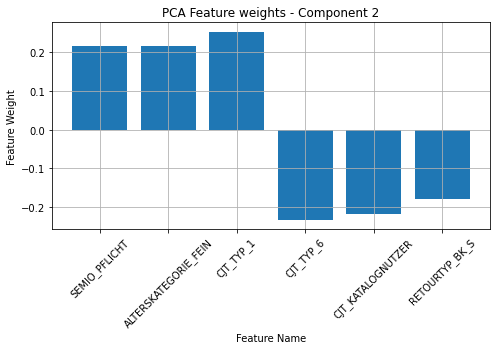

,Feature,Description,FeatureWeight
0,CJT_TYP_1,No description given,0.252437
1,ALTERSKATEGORIE_FEIN,No description given,0.215646
2,SEMIO_PFLICHT,affinity indicating in what way the person is ...,0.215512
3,RETOURTYP_BK_S,return type,-0.179648
4,CJT_KATALOGNUTZER,No description given,-0.217407
5,CJT_TYP_6,No description given,-0.232410


In [ ]:
component_2_info = plot_feature_weights(azdias, pca_azdias, attributes_info, 2, 3)
component_2_info.head(10)

Component 2:

* Has a high positive weight for CJT_TYP_1 and ALTERSKATEGORIE_FEIN .
* Has a high negative rate for RETURN TYPE.


##### **Component 3**

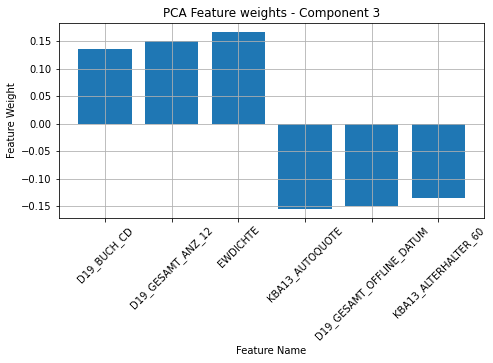

,Feature,Description,FeatureWeight
0,EWDICHTE,density of inhabitants per square kilometer,0.166706
1,D19_GESAMT_ANZ_12,No description given,0.149750
2,D19_BUCH_CD,No description given,0.136118
3,KBA13_ALTERHALTER_60,share of car owners between 46 and 60 within t...,-0.134626
4,D19_GESAMT_OFFLINE_DATUM,actuality of the last transaction with the com...,-0.149540
5,KBA13_AUTOQUOTE,share of cars per household within the PLZ8,-0.155321


In [ ]:
component_3_info = plot_feature_weights(azdias, pca_azdias, attributes_info, 3, 3)
component_3_info.head(10)

Component 3:

* Has a high positive weight for density of inhabitants per square kilometer.
* Has a high negative rate for share of cars per household within the PLZ8.


##### **Component 4**

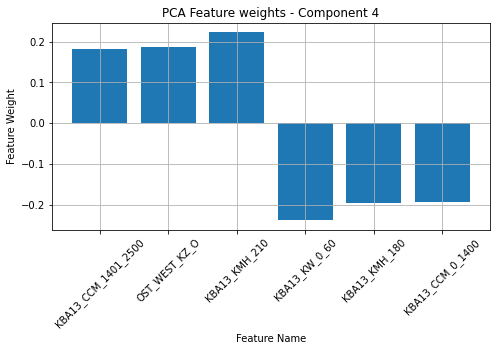

,Feature,Description,FeatureWeight
0,KBA13_KMH_210,No description given,0.223095
1,OST_WEST_KZ_O,No description given,0.186778
2,KBA13_CCM_1401_2500,No description given,0.182697
3,KBA13_CCM_0_1400,share of cars with less than 1401ccm within th...,-0.193594
4,KBA13_KMH_180,share of cars with max speed between 110 km/h ...,-0.196051
5,KBA13_KW_0_60,share of cars with less than 61 KW engine powe...,-0.238623


In [ ]:
component_4_info = plot_feature_weights(azdias, pca_azdias, attributes_info, 4, 3)
component_4_info.head(10)

Component 4:

* Has a high positive weight for KBA13_KMH_210.
* Has a high negative rate for share of cars with less than 61 KW engine powe.

### **1.2. Customer Segmentation - K-Means Clustering**

After reducing the number of dimensions, we will now use the K-Means Clustering algorithm to cluster the general population into different segments.

In [ ]:
def get_Kmeans_scores(data, K_start, K_end, step=1):
    
    scores = []
    
    print("Performing K-Means clustering")
    print("Given range min:{}, max:{}, step:{}".format(K_start, K_end, step))

    for n in range(K_start, K_end+1, step):
        
        print("\nTraining for n_clusters: ", n)
        start = time.time()
        
        kmeans = KMeans(n, random_state=SEED)
        model = kmeans.fit(data)
        scores.append(abs(model.score(data)))
        
        print("Done! Score: ", scores[-1])
        print("Time elapsed: {:.2f} sec.".format(time.time()-start))
        
    return scores, range(K_start, K_end+1, step)

In [ ]:
%%time
scores, range_ = get_Kmeans_scores(azdias_pca_150, 2, 20, 1)

Performing K-Means clustering
Given range min:2, max:20, step:1

Training for n_clusters:  2
Done! Score:  85720637.46052872
Time elapsed: 31.92 sec.

Training for n_clusters:  3
Done! Score:  83520238.6894784
Time elapsed: 159.60 sec.

Training for n_clusters:  4
Done! Score:  81983883.52001983
Time elapsed: 82.88 sec.

Training for n_clusters:  5
Done! Score:  80796922.02285603
Time elapsed: 103.53 sec.

Training for n_clusters:  6
Done! Score:  79807472.44664511
Time elapsed: 144.34 sec.

Training for n_clusters:  7
Done! Score:  79067482.95618129
Time elapsed: 149.00 sec.

Training for n_clusters:  8
Done! Score:  78422346.13910273
Time elapsed: 139.37 sec.

Training for n_clusters:  9
Done! Score:  77833922.959019
Time elapsed: 147.47 sec.

Training for n_clusters:  10
Done! Score:  77386006.39738397
Time elapsed: 216.48 sec.

Training for n_clusters:  11
Done! Score:  77013012.40802802
Time elapsed: 275.77 sec.

Training for n_clusters:  12
Done! Score:  76656724.97742248
Time el

In [ ]:
def plot_elbow(scores, range_):
    
    fig = plt.figure(figsize=(12,6))
    ax = fig.add_subplot(111)
    
    ax.plot(range_, scores, linestyle= "--",marker = "o", color="orange")
    ax.set_xlabel("No. of Clusters")
    ax.set_ylabel("Sum of squared distances")
    ax.set_title("Kmeans - Cluster distances vs No. of Clusters")
    
    plt.show()

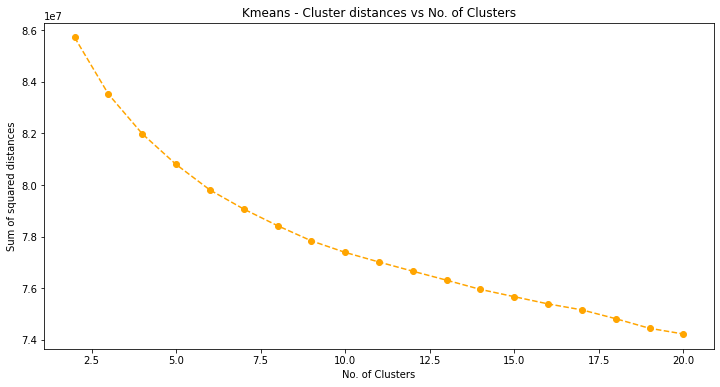

In [ ]:
plot_elbow(scores, range_)

##### **Choosing Number of Clusters**

The main idea behind clustering algorithms is to select the number of clusters so as to minimize the intra-cluster variation. In this process the elbow method is used to select the optimal number of clusters.  

The number of clusters can be selected in such a way that adding one more cluster to the existing clusters will not improve the intra-cluster variation. Which means adding a cluster will not reduce the sum of sqaured distances between the clusters.  

From the elbow above, we can see that the sum of sqaured error decreasing with a high slope until around 8 clusters and then the slope decreases.

In [ ]:
kmeans = KMeans(8, random_state=SEED)

kmeans.fit(azdias_pca_150)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=2, tol=0.0001, verbose=0)

In [ ]:
azdias_clusters = kmeans.predict(azdias_pca_150)

In [ ]:
customers_pca_150 = c_pca_150.transform(customers)

In [ ]:
customers_clusters = kmeans.predict(customers_pca_150)

In [ ]:
print(azdias_clusters[:15], "\n",customers_clusters[:15])

[7 0 7 7 1 5 7 7 6 0 6 3 1 7 1] 
 [6 1 1 0 0 1 0 0 0 1 7 0 0 1 1]


In [ ]:
customers_clusters = pd.Series(customers_clusters)
azdias_clusters = pd.Series(azdias_clusters)

In [ ]:
customers_clusters.value_counts().sort_index()

0    18513
1    28966
2     1328
3     1147
4      730
5       34
6    48900
7      723
dtype: int64

In [ ]:
azdias_clusters.value_counts().sort_index()

0    44018
1    66725
2    27196
3    48625
4    36993
5    59062
6    64075
7    68711
dtype: int64

**Population in each cluster**

The number of people coming under each cluster can be placed in a dataframe for further analysis.

In [ ]:
cluster_info = pd.DataFrame([])

cluster_info["Population"] = azdias_clusters.value_counts().sort_index()
cluster_info["Customers"] = customers_clusters.value_counts().sort_index()
cluster_info.reset_index(inplace=True)
cluster_info.rename(columns={"index":"Cluster"}, inplace=True)

In [ ]:
cluster_info

,Cluster,Population,Customers
0,0,44018,18513
1,1,66725,28966
2,2,27196,1328
3,3,48625,1147
4,4,36993,730
5,5,59062,34
6,6,64075,48900
7,7,68711,723


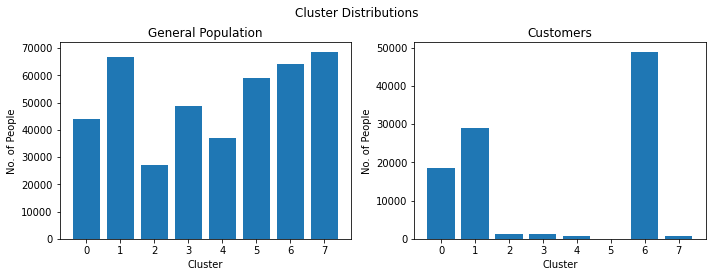

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 4))

ax1.bar(cluster_info["Cluster"], cluster_info["Population"])
ax1.set_xlabel("Cluster")
ax1.set_ylabel("No. of People")
ax1.set_title("General Population")

ax2.bar(cluster_info["Cluster"], cluster_info["Customers"])
ax2.set_xlabel("Cluster")
ax2.set_ylabel("No. of People")
ax2.set_title("Customers")

fig.suptitle("Cluster Distributions")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

**Population percentage per cluster.**

In [ ]:
cluster_info["Pop_proportion"] = (cluster_info["Population"]/cluster_info["Population"].sum()*100).round(2)
cluster_info["Cust_proportion"] = (cluster_info["Customers"]/cluster_info["Customers"].sum()*100).round(2)

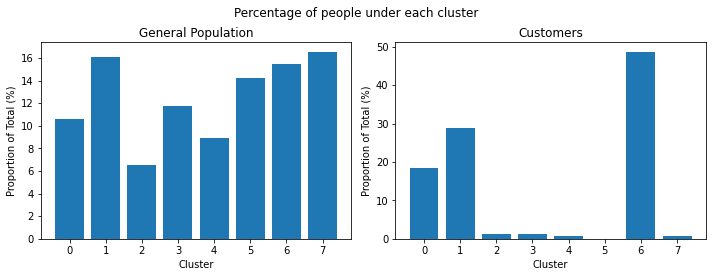

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 4))

ax1.bar(cluster_info["Cluster"], cluster_info["Pop_proportion"])
ax1.set_xlabel("Cluster")
ax1.set_ylabel("Proportion of Total (%)")
ax1.set_title("General Population")

ax2.bar(cluster_info["Cluster"], cluster_info["Cust_proportion"])
ax2.set_xlabel("Cluster")
ax2.set_ylabel("Proportion of Total (%)")
ax2.set_title("Customers")

fig.suptitle("Percentage of people under each cluster")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Observation: Moderately uniform distribution of polulation, highest number of customers in cluster 6 and lowest in cluster 5.

**Ratio of Proportion of Customers to Proportion of General Population in each cluster.** 

Ratio of customers proportion to general population proportion in each cluster. This gives an idea of which clusters are the customers of the mail order company from and where can the company acquire its new customers from.

In [ ]:
cluster_info["Cust_over_Pop"] = cluster_info["Cust_proportion"] / cluster_info["Pop_proportion"]

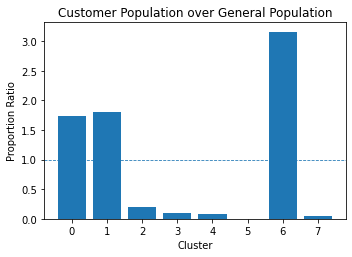

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(5, 4))

ax.bar(cluster_info["Cluster"], cluster_info["Cust_over_Pop"])
ax.set_xlabel("Cluster")
ax.set_ylabel("Proportion Ratio")
ax.set_title("Customer Population over General Population")
ax.axhline(y=1, linestyle = "--", linewidth = 0.8)

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

The ratio > 1 indicates that the cluster contains more customers, and there is a scope of the prople belonging to these clusters being future customers. 

*   The ratio between proportions of customers and population gave an idea about
*   what proportion of customers are there in each cluster.


This also gives an idea about which cluster can be targetted for future customers.

**What does each cluster represent?**

To answer this we can see which PCA component influences a given cluster most and then identifying which feature influences that pca component. This is done by the below function.

In [ ]:
def explain_cluster(kmeans_model, cluster_no, data, pca_model, attributes_info, num_components=2, num_feat_per_comp=3):
    
    weights = kmeans_model.cluster_centers_[cluster_no]
    components = list(range(len(weights)))
    
    cluster_expl = pd.DataFrame({"Weights":weights, "Component":components})
    cluster_expl.sort_values("Weights", ascending=False, inplace=True, ignore_index=True)

    comps = []
    weights = []
    comp_infos = []
    for index, row in cluster_expl.head(n=num_components).iterrows():
        
        component_info = plot_feature_weights(data, pca_model, attributes_info, 
                                                int(row["Component"]), num_feat_per_comp, False)
        comp_infos.append(component_info)
        comps += [int(row["Component"])] * len(component_info)
        weights +=  [row["Weights"]] * len(component_info)
        
    component_info = pd.concat(comp_infos, ignore_index=True)
    component_info.insert(0, "ComponentWeight", pd.Series(weights))
    component_info.insert(0, "Component", pd.Series(comps))
        
    return component_info

In [ ]:
cluster_0 = explain_cluster(kmeans, 0, azdias, pca_150, attributes_info)
cluster_0

,Component,ComponentWeight,Feature,Description,FeatureWeight
0,0,5.029825,KBA05_ANTG1,number of 1-2 family houses in the cell,0.172005
1,0,5.029825,KBA13_ANTG1,No description given,0.171904
2,0,5.029825,MOBI_RASTER,No description given,0.163316
3,0,5.029825,HH_EINKOMMEN_SCORE,estimated household_net_income,-0.175161
4,0,5.029825,CAMEO_INTL_2015,No description given,-0.182696
5,0,5.029825,CAMEO_DEUG_2015,CAMEO_4.0: uppergroup,-0.187231
6,2,3.136669,CJT_TYP_1,No description given,0.252437
7,2,3.136669,ALTERSKATEGORIE_FEIN,No description given,0.215646
8,2,3.136669,SEMIO_PFLICHT,affinity indicating in what way the person is ...,0.215512
9,2,3.136669,RETOURTYP_BK_S,return type,-0.179648


In [ ]:
cluster_1 = explain_cluster(kmeans, 1, azdias, pca_150, attributes_info)
cluster_1

,Component,ComponentWeight,Feature,Description,FeatureWeight
0,0,4.307149,KBA05_ANTG1,number of 1-2 family houses in the cell,0.172005
1,0,4.307149,KBA13_ANTG1,No description given,0.171904
2,0,4.307149,MOBI_RASTER,No description given,0.163316
3,0,4.307149,HH_EINKOMMEN_SCORE,estimated household_net_income,-0.175161
4,0,4.307149,CAMEO_INTL_2015,No description given,-0.182696
5,0,4.307149,CAMEO_DEUG_2015,CAMEO_4.0: uppergroup,-0.187231
6,7,0.252529,SEMIO_FAM,affinity indicating in what way the person is ...,0.276440
7,7,0.252529,SEMIO_SOZ,affinity indicating in what way the person is ...,0.256912
8,7,0.252529,KBA13_KMH_140_210,share of cars with max speed between 140 and 2...,0.177447
9,7,0.252529,SEMIO_DOM,affinity indicating in what way the person is ...,-0.234569


In [ ]:
cluster_6 = explain_cluster(kmeans, 6, azdias, pca_150, attributes_info)
cluster_6

,Component,ComponentWeight,Feature,Description,FeatureWeight
0,2,1.748180,CJT_TYP_1,No description given,0.252437
1,2,1.748180,ALTERSKATEGORIE_FEIN,No description given,0.215646
2,2,1.748180,SEMIO_PFLICHT,affinity indicating in what way the person is ...,0.215512
3,2,1.748180,RETOURTYP_BK_S,return type,-0.179648
4,2,1.748180,CJT_KATALOGNUTZER,No description given,-0.217407
5,2,1.748180,CJT_TYP_6,No description given,-0.232410
6,5,0.383873,KBA05_MAXVORB,most common preowner structure in the microcell,0.205708
7,5,0.383873,KBA05_ZUL1,share of cars built before 1994,0.196551
8,5,0.383873,KBA05_VORB2,share of cars with more than two preowner,0.184822
9,5,0.383873,KBA05_MAXBJ,most common age of the cars in the microcell,-0.191888


This above analysis helps in understanding the existing customers and their behaviour according to demographics and other data collected.

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [ ]:
mailout_train = pd.read_csv('Udacity_MAILOUT_052018_TRAIN.csv', sep=';')
mailout_train.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,...,RELAT_AB,RETOURTYP_BK_S,RT_KEIN_ANREIZ,RT_SCHNAEPPCHEN,RT_UEBERGROESSE,SEMIO_DOM,SEMIO_ERL,SEMIO_FAM,SEMIO_KAEM,SEMIO_KRIT,SEMIO_KULT,SEMIO_LUST,SEMIO_MAT,SEMIO_PFLICHT,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,SOHO_KZ,STRUKTURTYP,TITEL_KZ,UMFELD_ALT,UMFELD_JUNG,UNGLEICHENN_FLAG,VERDICHTUNGSRAUM,VERS_TYP,VHA,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,0.0,0.0,1.0,13.0,0.0,3.0,5.0,5D,5,34,2.0,5.0,2.0,2.0,5.0,5.0,5.0,5.0,0,0,10,0,0,0,10,10,0.0,0,0,0,...,5.0,5.0,2.0,5.0,1.0,6,7,2,6,6,1,7,1,3,2,1,5,1,3,3,0.0,3.0,0.0,2.0,4.0,0.0,4.0,2,1.0,2.0,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,0.0,0.0,2.0,1.0,0.0,2.0,5.0,5B,5,32,2.0,2.0,2.0,2.0,4.0,3.0,5.0,4.0,1,1,5,0,0,3,10,10,0.0,0,0,6,...,1.0,2.0,3.0,1.0,3.0,6,6,1,5,6,3,6,5,5,4,3,1,3,4,2,0.0,1.0,0.0,2.0,5.0,0.0,0.0,1,1.0,3.0,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,NaN,0.0,0.0,1.0,0.0,4.0,1.0,2D,2,14,4.0,5.0,1.0,1.0,5.0,5.0,5.0,5.0,0,1,7,0,0,0,10,7,0.0,5,0,0,...,4.0,3.0,1.0,5.0,2.0,3,3,4,1,3,4,7,6,1,1,5,3,1,7,3,0.0,3.0,0.0,1.0,5.0,0.0,10.0,1,4.0,1.0,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,0.0,0.0,2.0,4.0,0.0,4.0,2.0,2D,2,14,2.0,5.0,2.0,2.0,5.0,5.0,5.0,4.0,0,0,10,0,0,0,10,10,0.0,0,0,6,...,3.0,5.0,2.0,5.0,1.0,5,7,1,6,7,1,7,1,4,2,2,5,3,2,1,0.0,3.0,0.0,3.0,5.0,0.0,5.0,2,1.0,4.0,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,0.0,0.0,1.0,44.0,0.0,3.0,4.0,7B,7,41,6.0,5.0,1.0,2.0,5.0,5.0,5.0,5.0,0,0,10,0,0,0,10,10,0.0,0,5,0,...,3.0,5.0,1.0,5.0,1.0,5,4,6,2,5,5,6,6,4,5,4,6,2,7,1,0.0,3.0,0.0,2.0,5.0,0.0,4.0,1,0.0,4.0,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


In [ ]:
# Total number of records
n_records = mailout_train.shape[0]

# Number of records where the individual became a customer
n_customer = mailout_train[mailout_train['RESPONSE'] == 1].shape[0]

# Number of records where individual did not become a customer
n_not_customer = mailout_train[mailout_train['RESPONSE'] == 0].shape[0]

# Percentage of individuals who became customers
customer_perc = (n_customer / n_records) * 100

# Print the results
print("Total number of records: {}".format(n_records))
print("Individuals who became customers: {}".format(n_customer))
print("Individuals who did not become customers: {}".format(n_not_customer))
print("Percentage of individuals who became customers: {}%".format(customer_perc))

Total number of records: 42962
Individuals who became customers: 532
Individuals who did not become customers: 42430
Percentage of individuals who became customers: 1.2383036171500394%


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


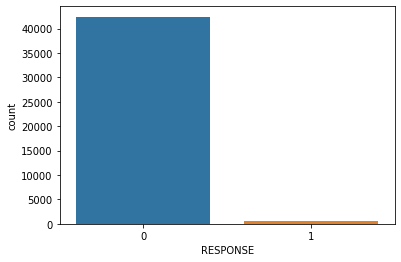

In [ ]:
sns.countplot("RESPONSE",data=mailout_train)

In [ ]:
X = mailout_train.drop('RESPONSE',axis=1)
y = mailout_train['RESPONSE']

In [ ]:
# Prepare the data using the function created earlier
mailout_train_clean = data_clean(X,False)

shape after corr (42962, 253)
shape after one-hot (42962, 300)
shape after impute (42962, 300)
shape after scaling (42962, 300)


In [ ]:
mailout_train_clean.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_3,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_OFFLINE_DATUM,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,...,CAMEO_DEU_2015_2D,CAMEO_DEU_2015_3A,CAMEO_DEU_2015_3B,CAMEO_DEU_2015_3C,CAMEO_DEU_2015_3D,CAMEO_DEU_2015_4A,CAMEO_DEU_2015_4B,CAMEO_DEU_2015_4C,CAMEO_DEU_2015_4D,CAMEO_DEU_2015_4E,CAMEO_DEU_2015_5A,CAMEO_DEU_2015_5B,CAMEO_DEU_2015_5C,CAMEO_DEU_2015_5D,CAMEO_DEU_2015_5E,CAMEO_DEU_2015_5F,CAMEO_DEU_2015_6A,CAMEO_DEU_2015_6B,CAMEO_DEU_2015_6C,CAMEO_DEU_2015_6D,CAMEO_DEU_2015_6E,CAMEO_DEU_2015_6F,CAMEO_DEU_2015_7A,CAMEO_DEU_2015_7B,CAMEO_DEU_2015_7C,CAMEO_DEU_2015_7D,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,CAMEO_DEU_2015_XX,OST_WEST_KZ_-1,OST_WEST_KZ_O,OST_WEST_KZ_W
LNR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
-1.656309,1.031262,-0.545883,-0.371726,-0.428455,0.573402,-0.499090,-0.204857,-0.752038,-0.083831,-0.459891,0.397200,0.355905,0.400669,-0.742850,0.777450,-0.396140,0.578977,0.596049,-0.224018,-0.386557,-0.311376,-0.131465,0.180465,-0.265409,-0.420594,-0.628321,-0.455670,-0.339433,-0.890460,-0.195661,-0.384801,-0.296902,-0.357622,-0.277236,-0.670418,0.332665,-0.614365,-0.656230,-0.499065,-0.506860,...,-0.220444,-0.089447,-0.094842,-0.193271,-0.229635,-0.201982,-0.106408,-0.233207,-0.102537,-0.084278,-0.104831,-0.101489,-0.0996,7.320490,-0.064501,-0.074794,-0.077728,-0.246025,-0.134286,-0.093838,-0.163382,-0.096944,-0.17254,-0.141559,-0.093964,-0.070587,-0.095589,-0.196488,-0.152626,-0.17432,-0.167172,-0.104604,-0.110149,-0.100902,-0.125771,-0.094216,-0.016003,-0.47014,-0.494196,0.778419
-1.655987,0.323502,0.396516,0.523127,0.837103,-0.445506,-0.499090,-0.204857,-0.402222,-0.083831,-0.860749,0.397200,0.355905,0.291572,-0.742850,-1.311754,-0.396140,-0.506087,-0.429151,1.978334,-0.386557,-0.311376,3.646454,0.180465,-0.265409,-0.420594,1.649422,-0.455670,-0.339433,-0.890460,-0.195661,3.005880,-0.296902,-0.357622,-0.277236,0.732700,-3.156901,1.570205,1.767892,-0.499065,-1.127931,...,-0.220444,-0.089447,-0.094842,-0.193271,-0.229635,-0.201982,-0.106408,-0.233207,-0.102537,-0.084278,-0.104831,9.853261,-0.0996,-0.136603,-0.064501,-0.074794,-0.077728,-0.246025,-0.134286,-0.093838,-0.163382,-0.096944,-0.17254,-0.141559,-0.093964,-0.070587,-0.095589,-0.196488,-0.152626,-0.17432,-0.167172,-0.104604,-0.110149,-0.100902,-0.125771,-0.094216,-0.016003,-0.47014,-0.494196,0.778419
-1.655785,0.323502,-0.545883,-0.192755,-0.681567,-0.518285,2.042255,-0.204857,-1.101855,-0.083831,-0.059034,-1.614354,-0.587345,-0.690293,0.391438,0.777450,-1.138807,0.578977,0.596049,-0.224018,-0.386557,-0.311376,-0.131465,0.180465,3.263468,-0.420594,-0.628321,-0.455670,-0.339433,-0.890460,-0.195661,-0.384801,-0.296902,-0.357622,-0.277236,-0.670418,-0.975922,-0.614365,-0.656230,-0.499065,-0.817396,...,4.536309,-0.089447,-0.094842,-0.193271,-0.229635,-0.201982,-0.106408,-0.233207,-0.102537,-0.084278,-0.104831,-0.101489,-0.0996,-0.136603,-0.064501,-0.074794,-0.077728,-0.246025,-0.134286,-0.093838,-0.163382,-0.096944,-0.17254,-0.141559,-0.093964,-0.070587,-0.095589,-0.196488,-0.152626,-0.17432,-0.167172,-0.104604,-0.110149,-0.100902,-0.125771,-0.094216,-0.016003,-0.47014,2.023489,-1.284655
-1.668538,1.031262,-0.545883,-0.729667,-0.934679,-0.227168,-0.499090,-0.204857,-0.402222,-0.083831,-0.059034,-1.111466,-0.587345,-0.690293,-0.742850,0.777450,-0.396140,0.578977,-0.429151,-0.224018,-0.386557,-0.311376,-0.131465

### **2.1 Classification**

First step to find a model with an adequate classification performance is testing several classification algorithms in their basic form, i.e. without tuning.

In [ ]:
param_grid={}

def classify(clf, param_grid, X_train=mailout_train_clean, y_train=y):
    """
    Fits a classifier to its training data and prints its ROC AUC score.
    
    INPUT:
    - clf (classifier): classifier to fit
    - param_grid (dict): classifier parameters used with GridSearchCV
    - X_train (DataFrame): training input
    - y_train (DataFrame): training output
            
    OUTPUT:
    - classifier: input classifier fitted to the training data
    """
    
    # cv uses StratifiedKFold
    # scoring roc_auc available as parameter
    grid = GridSearchCV(estimator=clf, param_grid = param_grid, scoring='roc_auc', cv=5)
    grid.fit(X_train, y_train)
    print(grid.best_score_)
    
    return grid.best_estimator_

In [ ]:
# LogisticRegression
lor = LogisticRegression(random_state=12)
classify(lor, {})

0.6585791172931088


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=12, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
# BaggingClassifier
bac = BaggingClassifier(random_state=28)
classify(bac, {})

0.5726102215800124


BaggingClassifier(base_estimator=None, bootstrap=True, bootstrap_features=False,
                  max_features=1.0, max_samples=1.0, n_estimators=10,
                  n_jobs=None, oob_score=False, random_state=28, verbose=0,
                  warm_start=False)

In [ ]:
# RandomForestClassifier
rfc = RandomForestClassifier(random_state=12)
classify(rfc, {})

0.5904622290541874


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=12, verbose=0,
                       warm_start=False)

In [ ]:
# AdaBoostClassifier
abc = AdaBoostClassifier(random_state=12)
abc_best_est = classify(abc, {})

0.7313571196522591


In [ ]:
# GradientBoostingClassifier
gbc = GradientBoostingClassifier(random_state=12)
classify(gbc, {})

0.7581946135269505


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=12, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

### **2.1 Model Tuning.**

In [ ]:
# tune the most promising classifier with the help of GridSearchCV
# the result is our model that will be used with the test set
gbc = GradientBoostingClassifier(random_state=12)
param_grid = {'loss': ['deviance', 'exponential'],
              'max_depth': [2, 3],
              'n_estimators':[80],
              'random_state': [12]
             }

gbc_best_est = classify(gbc, param_grid)
gbc_best_est

0.7673844143722899


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=2,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=80,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=12, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

### **2.2 Feature Selection.**

In [ ]:
# analyse the most important features of the model
fi = pd.DataFrame({'FI':gbc_best_est.feature_importances_},index=mailout_train_clean.columns)
fi_sorted = fi.sort_values(by=['FI'], ascending=False)
fi_sorted.head(10)

,FI
D19_SOZIALES,0.614864
ANZ_TITEL,0.026949
ANZ_KINDER,0.023925
D19_BANKEN_ANZ_12,0.015202
EINGEZOGENAM_HH_JAHR,0.015137
VERDICHTUNGSRAUM,0.013676
RT_SCHNAEPPCHEN,0.012319
KBA05_CCM4,0.011595
MIN_GEBAEUDEJAHR,0.009841
KBA05_DIESEL,0.008816


## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter.

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

### **3.1 Reading data and evaluation.**

In [ ]:
mailout_test = pd.read_csv('Udacity_MAILOUT_052018_TEST.csv', sep=';')

In [ ]:
mailout_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42833 entries, 0 to 42832
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(93), object(6)
memory usage: 119.6+ MB


In [ ]:
mailout_test.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,...,REGIOTYP,RELAT_AB,RETOURTYP_BK_S,RT_KEIN_ANREIZ,RT_SCHNAEPPCHEN,RT_UEBERGROESSE,SEMIO_DOM,SEMIO_ERL,SEMIO_FAM,SEMIO_KAEM,SEMIO_KRIT,SEMIO_KULT,SEMIO_LUST,SEMIO_MAT,SEMIO_PFLICHT,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,SOHO_KZ,STRUKTURTYP,TITEL_KZ,UMFELD_ALT,UMFELD_JUNG,UNGLEICHENN_FLAG,VERDICHTUNGSRAUM,VERS_TYP,VHA,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1754,2,1.0,7.0,NaN,NaN,NaN,NaN,6.0,2.0,0.0,0.0,2.0,2.0,0.0,3.0,6.0,2B,2,13,5.0,5.0,1.0,2.0,5.0,5.0,5.0,5.0,0,0,10,0,0,0,10,10,0.0,0,3,6,...,3.0,4.0,5.0,2.0,5.0,1.0,3,3,4,2,3,6,7,1,1,1,2,6,1,7,3,0.0,3.0,0.0,2.0,5.0,0.0,23.0,1,1.0,4.0,5.0,6.0,3.0,6.0,9.0,3.0,3,1,4
1,1770,-1,1.0,0.0,NaN,NaN,NaN,NaN,0.0,20.0,0.0,0.0,1.0,21.0,0.0,4.0,7.0,5A,5,31,1.0,5.0,2.0,2.0,5.0,5.0,4.0,5.0,0,0,10,0,0,0,10,10,0.0,0,0,6,...,4.0,5.0,5.0,1.0,5.0,1.0,3,7,4,3,3,4,5,4,3,3,3,6,1,6,2,0.0,3.0,0.0,4.0,3.0,0.0,0.0,1,1.0,1.0,5.0,2.0,1.0,6.0,9.0,5.0,3,1,4
2,1465,2,9.0,16.0,NaN,NaN,NaN,NaN,11.0,2.0,0.0,0.0,4.0,2.0,0.0,4.0,1.0,7A,7,41,2.0,5.0,2.0,2.0,5.0,5.0,5.0,5.0,0,0,10,0,0,0,10,10,0.0,0,0,0,...,6.0,5.0,5.0,2.0,5.0,1.0,5,7,1,6,4,2,7,1,4,3,1,4,3,3,3,0.0,3.0,0.0,1.0,5.0,1.0,15.0,1,1.0,3.0,9.0,6.0,3.0,2.0,9.0,4.0,3,2,4
3,1470,-1,7.0,0.0,NaN,NaN,NaN,NaN,0.0,1.0,0.0,0.0,0.0,1.0,0.0,4.0,1.0,2B,2,13,4.0,5.0,2.0,1.0,5.0,5.0,5.0,5.0,0,0,10,0,0,0,10,10,0.0,0,0,0,...,5.0,4.0,5.0,1.0,3.0,1.0,5,7,1,6,7,2,7,2,2,3,2,3,3,2,3,0.0,3.0,0.0,2.0,5.0,0.0,10.0,2,1.0,2.0,6.0,6.0,3.0,NaN,9.0,2.0,3,2,4
4,1478,1,1.0,21.0,NaN,NaN,NaN,NaN,13.0,1.0,0.0,0.0,4.0,1.0,0.0,3.0,6.0,5A,5,31,6.0,1.0,3.0,2.0,4.0,4.0,4.0,3.0,3,4,2,2,2,0,8,2,10.0,6,6,6,...,4.0,2.0,3.0,3.0,2.0,3.0,6,7,2,5,4,2,5,2,3,3,2,5,3,3,3,0.0,2.0,0.0,5.0,5.0,0.0,0.0,1,1.0,1.0,2.0,4.0,3.0,3.0,9.0,7.0,4,2,4


### **3.2 Data Processing.**

In [ ]:
lnr = mailout_test.LNR

In [ ]:
mailout_test_clean  = data_clean(mailout_test ,False)

shape after corr (42833, 253)
shape after one-hot (42833, 300)
shape after impute (42833, 300)
shape after scaling (42833, 300)


### **3.3 Classification.**

In [ ]:
# use the trained model from Part 2 to predict the probabilties of the testing data 
response_test = gbc_best_est.predict_proba(mailout_test_clean)
response_test

array([[0.96173212, 0.03826788],
       [0.96964337, 0.03035663],
       [0.99317178, 0.00682822],
       ...,
       [0.98568067, 0.01431933],
       [0.96590879, 0.03409121],
       [0.97808447, 0.02191553]])

### **3.4 Kaggle Output.**

In [ ]:
# generate result file for the competition
result = pd.DataFrame({'LNR':lnr, 'RESPONSE':response_test[:,0]})
result.to_csv(path_or_buf='./result.csv', index=False)
result.head(10)

,LNR,RESPONSE
0,1754,0.961732
1,1770,0.969643
2,1465,0.993172
3,1470,0.995922
4,1478,0.994163
5,1782,0.994637
6,1485,0.996043
7,1519,0.976895
8,1835,0.982302
9,1522,0.995491
